In [100]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

In [2]:
image = cv2.imread('/Users/usmanr/Downloads/download.jpeg')

In [7]:
height, width, _ = image.shape

In [6]:
image.shape

(197, 256, 3)

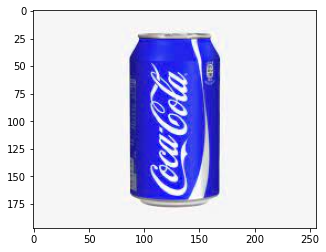

In [3]:
plt.imshow(image)

In [51]:
# assume you have a 16 x 16 box in the centre of the image
box_cx = 0.25
box_cy = 0.5
box_width = 50 / width
box_height = 50 / height

In [52]:
(box_cx, box_cy, box_width, box_height)

(0.25, 0.5, 0.1953125, 0.25380710659898476)

In [53]:
for ar in aspect_ratios:
    box_width = box_width * np.sqrt(ar)
    box_height = box_height / np.sqrt(ar)

In [54]:
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H

    voc = []

    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))

    return [int(v) for v in voc]

start_x, start_y, end_x, end_y = yoloFormattocv(box_cx, box_cy, box_width, box_height, height, width)

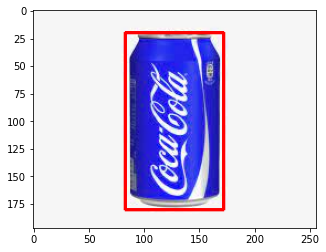

In [249]:
image = cv2.imread('/Users/usmanr/Downloads/download.jpeg')

image = cv2.rectangle(image, [83, 20], [172, 180], color, thickness)

plt.imshow(image)

In [254]:
gt_boxes = np.array([[83 / width, 20 / height, 172 / width, 180 / height]])

gt_boxes

array([[0.32421875, 0.10152284, 0.671875  , 0.91370558]])

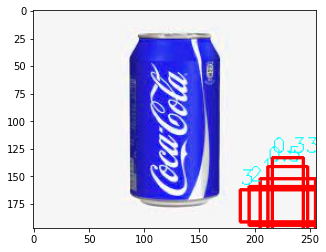

In [97]:
# 4:3 2:1 1 1:2 3:4
aspect_ratios = [1,2,3,1/2,0.33]

w = 50
h = 50

box_cx = 0.9
box_cy = 0.9
box_width = w / width
box_height = h / height

color = (255, 0, 0)
text_color = (0, 255, 255)
  
# Line thickness of 2 px
thickness = 2

image = cv2.imread('/Users/usmanr/Downloads/download.jpeg')

for ar in aspect_ratios:
    box_width_ = box_width * np.sqrt(ar)
    box_height_ = box_height / np.sqrt(ar)
    
    start_x, start_y, end_x, end_y = yoloFormattocv(box_cx, box_cy, box_width_, box_height_, height, width)

    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color, thickness)
    label = str(ar)
    image = cv2.putText(image, label, (start_x, start_y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1)

plt.imshow(image)

In [59]:
for ar in aspect_ratios:
    print(ar, np.sqrt(ar))

1 1.0
0.5 0.7071067811865476
0.333 0.5770615218501404
2 1.4142135623730951
1.333 1.1545561917897282


In [11]:

width_height = []
norm_width = 1
norm_height = 1

for ar in aspect_ratios:
    box_width = norm_width * np.sqrt(ar)
    box_height = norm_height / np.sqrt(ar)
    width_height.append((box_width, box_height))

In [60]:
0.95 / 0.735

1.292517006802721

In [61]:
4 / 3

1.3333333333333333

In [ ]:
# now an array of (width, height)
width_height = np.array(width_height)

In [68]:
5 / np.sqrt(2)

3.5355339059327373

In [288]:
hyper_params = {"feature_map_shapes": [38, 19, 10, 5, 3, 1], 
                "aspect_ratios": [[1., 2., 1./2.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2., 3., 1./3.],
                         [1., 2., 1./2.],
                         [1., 2., 1./2.]]
               }

def get_scale_for_nth_feature_map(k, m=6, scale_min=0.2, scale_max=0.9):
    """Calculating scale value for nth feature map using the given method in the paper.
    inputs:
        k = nth feature map for scale calculation
        m = length of all using feature maps for detections, 6 for ssd300
    outputs:
        scale = calculated scale value for given index
    """
    return scale_min + ((scale_max - scale_min) / (m - 1)) * (k - 1)

def generate_base_prior_boxes(aspect_ratios, feature_map_index, total_feature_map):
    """Generating top left prior boxes for given stride, height and width pairs of different aspect ratios.
    These prior boxes same with the anchors in Faster-RCNN.
    inputs:
        aspect_ratios = for all feature map shapes + 1 for ratio 1
        feature_map_index = nth feature maps for scale calculation
        total_feature_map = length of all using feature map for detections, 6 for ssd300
    outputs:
        base_prior_boxes = (prior_box_count, [y1, x1, y2, x2])
    """
    current_scale = get_scale_for_nth_feature_map(feature_map_index, m=total_feature_map)
    next_scale = get_scale_for_nth_feature_map(feature_map_index + 1, m=total_feature_map)
    base_prior_boxes = []
    for aspect_ratio in aspect_ratios:
        height = current_scale / tf.sqrt(aspect_ratio)
        width = current_scale * tf.sqrt(aspect_ratio)
        base_prior_boxes.append([-height/2, -width/2, height/2, width/2])
    # 1 extra pair for ratio 1
    height = width = tf.sqrt(current_scale * next_scale)
    base_prior_boxes.append([-height/2, -width/2, height/2, width/2])
    return tf.cast(base_prior_boxes, dtype=tf.float32)

def generate_prior_boxes(feature_map_shapes, aspect_ratios):
    """Generating top left prior boxes for given stride, height and width pairs of different aspect ratios.
    These prior boxes same with the anchors in Faster-RCNN.
    inputs:
        feature_map_shapes = for all feature map output size
        aspect_ratios = for all feature map shapes + 1 for ratio 1
    outputs:
        prior_boxes = (total_prior_boxes, [y1, x1, y2, x2])
            these values in normalized format between [0, 1]
    """
    prior_boxes = []
    for i, feature_map_shape in enumerate(feature_map_shapes):
        base_prior_boxes = generate_base_prior_boxes(aspect_ratios[i], i+1, len(feature_map_shapes))
        #
        stride = 1 / feature_map_shape
        print(stride)
        grid_coords = tf.cast(tf.range(0, feature_map_shape) / feature_map_shape + stride / 2, dtype=tf.float32)
        grid_x, grid_y = tf.meshgrid(grid_coords, grid_coords)
        flat_grid_x, flat_grid_y = tf.reshape(grid_x, (-1, )), tf.reshape(grid_y, (-1, ))
        #
        grid_map = tf.stack([flat_grid_y, flat_grid_x, flat_grid_y, flat_grid_x], -1)
        #
        prior_boxes_for_feature_map = tf.reshape(base_prior_boxes, (1, -1, 4)) + tf.reshape(grid_map, (-1, 1, 4))
        prior_boxes_for_feature_map = tf.reshape(prior_boxes_for_feature_map, (-1, 4))
        #
        prior_boxes.append(prior_boxes_for_feature_map)
    prior_boxes = tf.concat(prior_boxes, axis=0)
    return tf.clip_by_value(prior_boxes, 0, 1)
                
prior_boxes = generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])

0.02631578947368421
0.05263157894736842
0.1
0.2
0.3333333333333333
1.0


In [289]:
start_x, start_y, end_x, end_y = prior_boxes[0].numpy()

In [290]:
prior_boxes.shape

TensorShape([8732, 4])

In [305]:
prior_boxes[8204]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.03430781, 0.21143593, 0.86569214, 0.48856407], dtype=float32)>

59 0 196 197


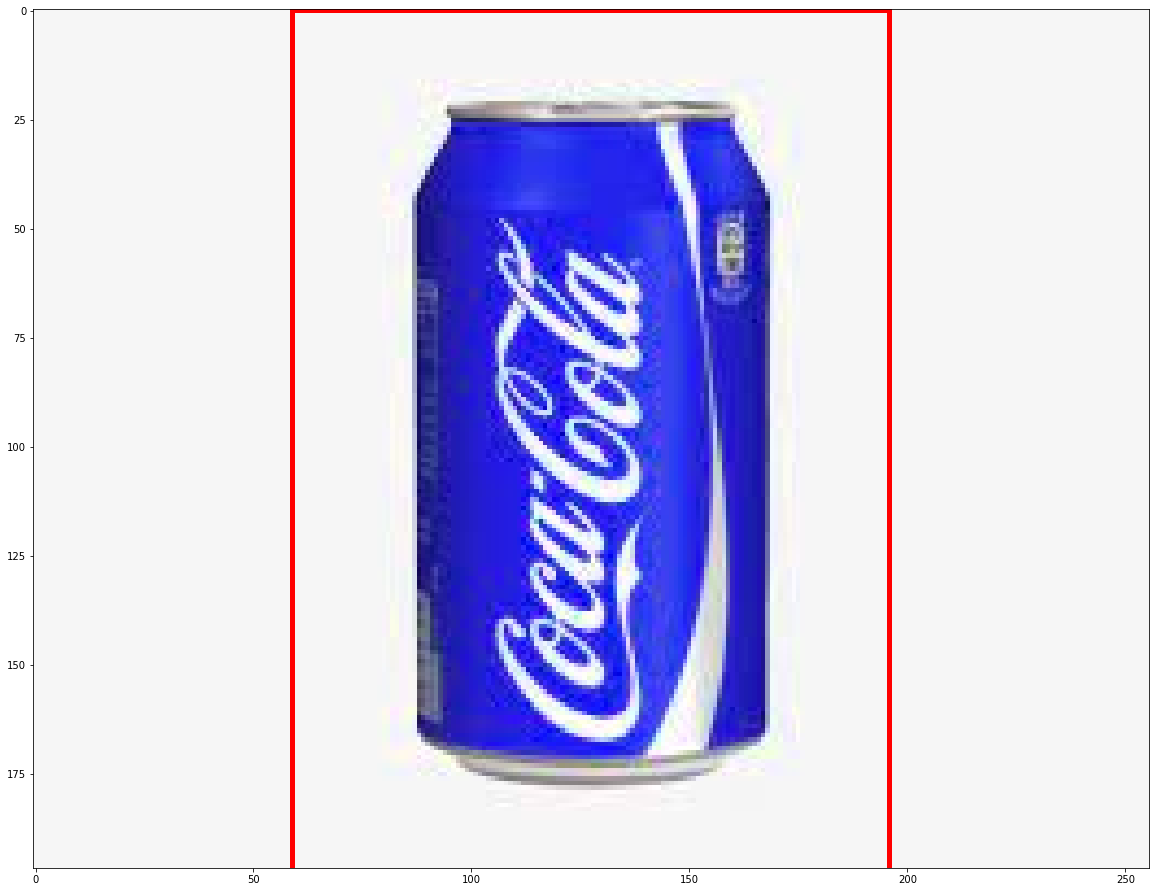

In [313]:
image = cv2.imread('/Users/usmanr/Downloads/download.jpeg')

for pr in prior_boxes[8709:8710]:
    
    start_x, start_y, end_x, end_y = pr.numpy()
    
    start_x, start_y, end_x, end_y = int(start_x * width), int(start_y * height), int(end_x * width), int(end_y * height)
    
    print(start_x, start_y, end_x, end_y)
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], color, thickness = 1)

plt.figure(figsize = (20,20))
plt.imshow(image)

In [292]:
prior_boxes[35:40]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.        , 0.09330015, 0.14354195, 0.35406828],
       [0.        , 0.15      , 0.1131579 , 0.35      ],
       [0.        , 0.10857864, 0.08386858, 0.39142138],
       [0.        , 0.17928931, 0.15457925, 0.3207107 ],
       [0.        , 0.11961594, 0.14354195, 0.38038406]], dtype=float32)>

In [293]:
gt_boxes = tf.constant([[[83 / width, 20 / height, 172 / width, 180 / height]]])

gt_boxes

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0.32421875, 0.10152284, 0.671875  , 0.9137056 ]]], dtype=float32)>

In [294]:
gt_rank = tf.rank(gt_boxes)
gt_expand_axis = gt_rank - 2
#
bbox_y1, bbox_x1, bbox_y2, bbox_x2 = tf.split(prior_boxes, 4, axis=-1)
gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(gt_boxes, 4, axis=-1)
# Calculate bbox and ground truth boxes areas
gt_area = tf.squeeze((gt_y2 - gt_y1) * (gt_x2 - gt_x1), axis=-1)
bbox_area = tf.squeeze((bbox_y2 - bbox_y1) * (bbox_x2 - bbox_x1), axis=-1)

In [295]:
gt_area

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2823604]], dtype=float32)>

In [296]:
gt_x1

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.10152284]]], dtype=float32)>

In [297]:
tf.transpose(gt_x1, [0,1,2])

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.10152284]]], dtype=float32)>

In [298]:
transpose_perm=[0, 2, 1]
x_top = tf.maximum(bbox_x1, tf.transpose(gt_x1, transpose_perm))

In [299]:
x_top

<tf.Tensor: shape=(1, 8732, 1), dtype=float32, numpy=
array([[[0.10152284],
        [0.10152284],
        [0.10152284],
        ...,
        [0.10152284],
        [0.18180197],
        [0.10152284]]], dtype=float32)>

In [301]:
def generate_iou_map(bboxes, gt_boxes, transpose_perm=[0, 2, 1]):
    """Calculating intersection over union values for each ground truth boxes in a dynamic manner.
    It is supported from 1d to 3d dimensions for bounding boxes.
    Even if bboxes have different rank from gt_boxes it should be work.
    inputs:
        bboxes = (dynamic_dimension, [y1, x1, y2, x2])
        gt_boxes = (dynamic_dimension, [y1, x1, y2, x2])
        transpose_perm = (transpose_perm_order)
            for 3d gt_boxes => [0, 2, 1]
    outputs:
        iou_map = (dynamic_dimension, total_gt_boxes)
            same rank with the gt_boxes
    """
    gt_rank = tf.rank(gt_boxes)
    gt_expand_axis = gt_rank - 2
    #
    bbox_y1, bbox_x1, bbox_y2, bbox_x2 = tf.split(bboxes, 4, axis=-1)
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(gt_boxes, 4, axis=-1)
    # Calculate bbox and ground truth boxes areas
    gt_area = tf.squeeze((gt_y2 - gt_y1) * (gt_x2 - gt_x1), axis=-1)
    bbox_area = tf.squeeze((bbox_y2 - bbox_y1) * (bbox_x2 - bbox_x1), axis=-1)
    #
    x_top = tf.maximum(bbox_x1, tf.transpose(gt_x1, transpose_perm))
    y_top = tf.maximum(bbox_y1, tf.transpose(gt_y1, transpose_perm))
    x_bottom = tf.minimum(bbox_x2, tf.transpose(gt_x2, transpose_perm))
    y_bottom = tf.minimum(bbox_y2, tf.transpose(gt_y2, transpose_perm))
    ### Calculate intersection area
    intersection_area = tf.maximum(x_bottom - x_top, 0) * tf.maximum(y_bottom - y_top, 0)
    ### Calculate union area
    union_area = (tf.expand_dims(bbox_area, -1) + tf.expand_dims(gt_area, gt_expand_axis) - intersection_area)
    # Intersection over Union
    return intersection_area / union_area

iou_map = generate_iou_map(prior_boxes, gt_boxes)

In [329]:
def get_deltas_from_bboxes(bboxes, gt_boxes):
    """Calculating bounding box deltas for given bounding box and ground truth boxes.
    inputs:
        bboxes = (total_bboxes, [y1, x1, y2, x2])
        gt_boxes = (batch_size, total_bboxes, [y1, x1, y2, x2])
    outputs:
        final_deltas = (batch_size, total_bboxes, [delta_y, delta_x, delta_h, delta_w])
    """
    bbox_width = bboxes[..., 3] - bboxes[..., 1]
    bbox_height = bboxes[..., 2] - bboxes[..., 0]
    bbox_ctr_x = bboxes[..., 1] + 0.5 * bbox_width
    bbox_ctr_y = bboxes[..., 0] + 0.5 * bbox_height
    #
    gt_width = gt_boxes[..., 3] - gt_boxes[..., 1]
    gt_height = gt_boxes[..., 2] - gt_boxes[..., 0]
    gt_ctr_x = gt_boxes[..., 1] + 0.5 * gt_width
    gt_ctr_y = gt_boxes[..., 0] + 0.5 * gt_height
    #
    bbox_width = tf.where(tf.equal(bbox_width, 0), 1e-3, bbox_width)
    bbox_height = tf.where(tf.equal(bbox_height, 0), 1e-3, bbox_height)
    delta_x = tf.where(tf.equal(gt_width, 0), tf.zeros_like(gt_width), tf.truediv((gt_ctr_x - bbox_ctr_x), bbox_width))
    delta_y = tf.where(tf.equal(gt_height, 0), tf.zeros_like(gt_height), tf.truediv((gt_ctr_y - bbox_ctr_y), bbox_height))
    delta_w = tf.where(tf.equal(gt_width, 0), tf.zeros_like(gt_width), tf.math.log(gt_width / bbox_width))
    delta_h = tf.where(tf.equal(gt_height, 0), tf.zeros_like(gt_height), tf.math.log(gt_height / bbox_height))
    #
    return tf.stack([delta_y, delta_x, delta_h, delta_w], axis=-1)

In [332]:
max_indices_each_gt_box = tf.argmax(iou_map, axis=2, output_type=tf.int32)
merged_iou_map = tf.reduce_max(iou_map, axis=2)
pos_cond = tf.greater(merged_iou_map, 0.5)
gt_boxes_map = tf.gather(gt_boxes, max_indices_each_gt_box, batch_dims=1)
expanded_gt_boxes = tf.where(tf.expand_dims(pos_cond, -1), gt_boxes_map, tf.zeros_like(gt_boxes_map))
variances = [0.1, 0.1, 0.2, 0.2]
bbox_deltas = get_deltas_from_bboxes(prior_boxes, expanded_gt_boxes) #/ variances

In [333]:
bbox_deltas

<tf.Tensor: shape=(1, 8732, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]], dtype=float32)>

In [321]:
gt_boxes

<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=array([[[0.32421875, 0.10152284, 0.671875  , 0.9137056 ]]], dtype=float32)>

In [335]:
tf.cast(32, tf.int32)

<tf.Tensor: shape=(), dtype=int32, numpy=32>